In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
shruthisindhura_pestopia_path = kagglehub.dataset_download('shruthisindhura/pestopia')

print('Data source import complete.')


100%|██████████| 2.10G/2.10G [00:36<00:00, 62.6MB/s]

Extracting files...


Data source import complete.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob as gb
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau , ModelCheckpoint
from keras.applications.mobilenet import MobileNet ,preprocess_input

In [ ]:
from PIL import Image

In [ ]:
def g_r(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'g', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [ ]:
path = "/content/drive/MyDrive/archive/Datasets/Pest_Dataset"


training=tf.keras.preprocessing.image.ImageDataGenerator(
    zca_epsilon=1e-06,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.05
).flow_from_directory(path,batch_size=16,target_size=(224,224),subset="training")

validing=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.05
).flow_from_directory(path,batch_size=16,target_size=(224,224),subset='validation',shuffle=False)

testing=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
).flow_from_directory(path,batch_size=16,target_size=(224,224),shuffle=False)


Found 478 images belonging to 132 classes.
Found 24 images belonging to 132 classes.
Found 502 images belonging to 132 classes.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def predictor(test_gen, test_steps, cmcmap, model):
    y_pred = []
    error_list = []
    error_pred_list = []
    y_true = test_gen.labels
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)
    errors = 0

    # Predict using the EfficientNet-B0 model
    preds = model.predict(test_gen, verbose=1)
    tests = len(preds)

    for i, p in enumerate(preds):
        pred_index = np.argmax(p)  # Index of the predicted class
        true_index = test_gen.labels[i]  # Integer values of the actual labels

        if pred_index != true_index:  # Misclassification
            errors += 1
            file = test_gen.filenames[i]
            error_list.append(file)
            error_class = classes[pred_index]
            error_pred_list.append(error_class)

        y_pred.append(pred_index)

    # Accuracy calculation
    acc = (1 - errors / tests) * 100
    msg = f'There were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%'
    print(msg)

    ypred = np.array(y_pred)
    ytrue = np.array(y_true)

    # F1-score calculation
    f1score = f1_score(ytrue, ypred, average='weighted') * 100

    # Plot confusion matrix if the class count is <= 30
    if class_count <= 30:
        cm = confusion_matrix(ytrue, ypred)
        # Plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap=cmcmap, cbar=False)
        plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    # Print classification report
    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n", clr)

    return errors, tests, error_list, error_pred_list, f1score


In [ ]:
input_shape_res=(224,224,3)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model


In [ ]:
from tensorflow.keras.applications import EfficientNetB0

# Create the base pre-trained model
base_model = EfficientNetB0(include_top=False, weights='imagenet')


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the EfficientNetB0 base model
base_model = EfficientNetB0(include_top=False, weights='imagenet')

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(132, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Print model summary (optional)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, None, None, 3)  │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, None, None, 3)  │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, None, None, 3)  │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, None, None, 3)  │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, None, None, 32) │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, None, None, 32) │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, None, None, 32) │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, None, None, 32) │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, None, None, 32) │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, None, None, 32) │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 5,496,615 (20.97 MB)

 Trainable params: 5,454,592 (20.81 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
num_classes=132

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Define the EfficientNetB0 model
def efficientnet(input_shape, num_classes):
    # Load the pre-trained EfficientNetB0 model without the top layer
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Pooling layer
    outputs = Dense(num_classes, activation='softmax')(x)  # Output layer

    # Create the final model
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Input shape and number of classes
input_shape_eff = (224, 224, 3)  # Update as per your dataset
num_classes = 9  # Adjust to your problem

# Initialize the EfficientNetB0 model
model2 = efficientnet(input_shape_eff, num_classes)

# Compile the model
model2.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Print model summary (optional)
model2.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 224, 224, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,061,100 (15.49 MB)

 Trainable params: 4,019,077 (15.33 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ... (Your EfficientNetB0 model definition - efficientnet function) ...

# Input shape and number of classes
input_shape_eff = (224, 224, 3)
# Update num_classes to match the actual number of classes in your dataset
num_classes = 2 # This should be 2 based on the error message

# Initialize the EfficientNetB0 model
model2 = efficientnet(input_shape_eff, num_classes)

# Compile the model
model2.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Define data generators
# Replace 'path/to/your/training/data'
# with the actual path to your data directory containing subdirectories for classes
train_datagen = ImageDataGenerator(
    # ... (Your data augmentation settings) ...
)

val_datagen = ImageDataGenerator(
    # ... (Your data augmentation settings for validation) ...
)

# Corrected path to your training data directory
# Assuming 'Pesticide_Dataset' has subfolders for train and validation data
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/archive/Datasets', # Specify training data subdirectory
    target_size=input_shape_eff[:2],
    batch_size=32,  # Adjust as needed
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/archive/Datasets', # Specify validation data subdirectory
    target_size=input_shape_eff[:2],
    batch_size=32,  # Adjust as needed
    class_mode='categorical'
)

# Define callbacks
EarlyStop = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
Reduce_LR = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=2, min_lr=0.00001)
Model_Checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', verbose=1, save_best_only=True)

callback = [EarlyStop, Reduce_LR, Model_Checkpoint]

# Training the EfficientNetB0 model
# Calculate test_steps based on your validation data
test_steps = val_generator.samples // val_generator.batch_size
num_epochs = 10 # or any desired number of epochs

# Check if val_generator has samples before fitting
if val_generator.samples > 0:
    history = model2.fit(
        train_generator,
        validation_data=val_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_steps=test_steps,
        epochs=num_epochs,
        callbacks=callback
    )
else:
    print("Error: No validation data found. Check your validation data directory.")

Found 502 images belonging to 2 classes.
Found 502 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - AUC: 0.9184 - Precision: 0.8795 - Recall: 0.8795 - accuracy: 0.8795 - loss: 0.2733 
Epoch 1: val_loss improved from inf to 0.00020, saving model to model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 271s 14s/step - AUC: 0.9232 - Precision: 0.8847 - Recall: 0.8847 - accuracy: 0.8847 - loss: 0.2628 - val_AUC: 1.0000 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 2.0239e-04 - learning_rate: 0.0010
Epoch 2/10
 1/15 ━━━━━━━━━━━━━━━━━━━━ 2:42 12s/step - AUC: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - accuracy: 1.0000 - loss: 4.7473e-04

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.00020 to 0.00014, saving model to model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - AUC: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - accuracy: 1.0000 - loss: 4.7473e-04 - val_AUC: 1.0000 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 1.4379e-04 - learning_rate: 0.0010
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - AUC: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - accuracy: 1.0000 - loss: 3.9019e-04 
Epoch 3: val_loss improved from 0.00014 to 0.00001, saving model to model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 236s 14s/step - AUC: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - accuracy: 1.0000 - loss: 3.8166e-04 - val_AUC: 1.0000 - val_Precision: 1.0000 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 9.3328e-06 - learning_rate: 0.0010
Epoch 4/10
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1:21 6s/step - AUC: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - accuracy: 1.0000 - loss: 7.0668e-05
Epoch 4: val_loss did not improv

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ... (Your EfficientNetB0 model definition - efficientnet function) ...

# Input shape and number of classes
input_shape_eff = (224, 224, 3)
# Update num_classes to match the actual number of classes in your dataset
num_classes = 2  # Changed from 9 to 2

# Initialize the EfficientNetB0 model
model2 = efficientnet(input_shape_eff, num_classes)

# Compile the model
model2.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Define the EfficientNetB0 model
def efficientnet(input_shape, num_classes):
    # Load the pre-trained EfficientNetB0 model without the top layer
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Global Average Pooling
    x = Dropout(0.5)(x)  # Dropout to prevent overfitting
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Set input shape and number of classes
input_shape_eff = (224, 224, 3)  # Adjust to match your dataset
num_classes = 2  # Adjust as per your use case

# Initialize the EfficientNetB0 model
model = efficientnet(input_shape_eff, num_classes)

# Compile the model with reduced learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Lower learning rate for gradual improvement
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Define data generators with augmentation for training and validation datasets
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()  # No augmentation for validation data

# Paths to training and validation data
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/archive/Datasets',  # Path to training data
    target_size=input_shape_eff[:2],
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/archive/Datasets',  # Path to validation data
    target_size=input_shape_eff[:2],
    batch_size=32,
    class_mode='categorical'
)

# Compute class weights (optional, for imbalanced datasets)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6),
    ModelCheckpoint('efficientnet_best_model.keras', save_best_only=True, monitor='val_loss', verbose=1)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=4,  # Set to a reasonable number for gradual convergence
    callbacks=callbacks,
    class_weight=class_weight_dict  # Use class weights for imbalanced
)

Found 502 images belonging to 2 classes.
Found 502 images belonging to 2 classes.
Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - AUC: 0.5980 - Precision: 0.5670 - Recall: 0.5670 - accuracy: 0.5670 - loss: 0.7281 
Epoch 1: val_loss improved from inf to 0.45301, saving model to efficientnet_best_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 278s 13s/step - AUC: 0.6073 - Precision: 0.5745 - Recall: 0.5745 - accuracy: 0.5745 - loss: 0.7219 - val_AUC: 0.9536 - val_Precision: 0.8917 - val_Recall: 0.8917 - val_accuracy: 0.8917 - val_loss: 0.4530 - learning_rate: 1.0000e-04
Epoch 2/4
 1/15 ━━━━━━━━━━━━━━━━━━━━ 2:36 11s/step - AUC: 0.9590 - Precision: 0.8438 - Recall: 0.8438 - accuracy: 0.8438 - loss: 0.4675

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.45301 to 0.41049, saving model to efficientnet_best_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - AUC: 0.9590 - Precision: 0.8438 - Recall: 0.8438 - accuracy: 0.8438 - loss: 0.4675 - val_AUC: 0.9855 - val_Precision: 0.9545 - val_Recall: 0.9545 - val_accuracy: 0.9545 - val_loss: 0.4105 - learning_rate: 1.0000e-04
Epoch 3/4
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - AUC: 0.9740 - Precision: 0.9236 - Recall: 0.9236 - accuracy: 0.9236 - loss: 0.3709 
Epoch 3: val_loss improved from 0.41049 to 0.22941, saving model to efficientnet_best_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 239s 13s/step - AUC: 0.9751 - Precision: 0.9253 - Recall: 0.9253 - accuracy: 0.9253 - loss: 0.3676 - val_AUC: 0.9971 - val_Precision: 0.9667 - val_Recall: 0.9667 - val_accuracy: 0.9667 - val_loss: 0.2294 - learning_rate: 1.0000e-04
Epoch 4/4
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1:16 5s/step - AUC: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - accuracy: 1.0000 - loss: 0.2265
Epoch 4: val_l

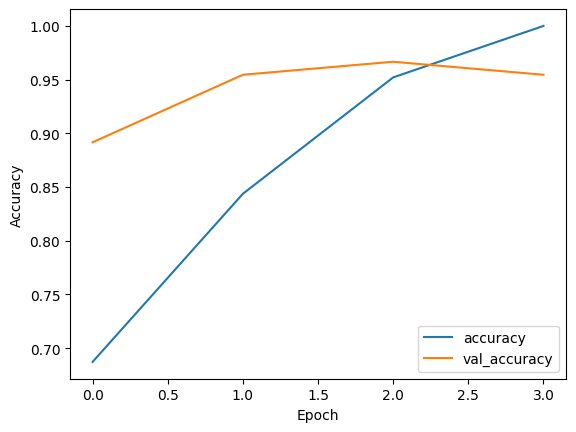

In [ ]:
# Assuming 'g_r' was intended to be a function for generating graphs or reports
import matplotlib.pyplot as plt  # Import matplotlib for plotting

def generate_report(history):
  """Generates graphs and reports based on the training history."""
  # Example: Plot training accuracy and loss
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

  # You can add more plotting or reporting logic here

# Call the function with the training history
generate_report(history)  # Assuming 'history' is the variable storing training history

In [ ]:
from sklearn.metrics import classification_report, f1_score

# Define the prediction and evaluation function
def efficientnet_predictor(model, testing_data, class_names=None):
    # Perform predictions on the entire testing data
    predictions = model.predict(testing_data, steps=len(testing_data), verbose=1)

    # Get true labels
    true_labels = testing_data.classes  # Use .classes instead of .labels
    predicted_labels = predictions.argmax(axis=1)  # Convert probabilities to class indices

    # Automatically determine number of classes
    num_classes = len(set(true_labels))

    # If class_names is not provided or has incorrect length, generate default names
    if class_names is None or len(class_names) != num_classes:
        class_names = [f"Class{i}" for i in range(num_classes)]
    # Calculate F1 score (macro)
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    print(f"Macro F1 Score: {f1:.4f}")

    # Identify misclassified samples
    error_list = [i for i, (true, pred) in enumerate(zip(true_labels, predicted_labels)) if true != pred]
    error_pred_list = [predicted_labels[i] for i in error_list]

    # Return errors, true labels, predictions, and F1 score
    return error_list, true_labels, error_pred_list, f1

# Example usage:
# If you know the class names, provide them:
# class_names = ['class1', 'class2', ..., 'class10']  # Replace with your actual class names

# Assuming 'val_generator' is your validation data generator
# Or let the function automatically handle it:
# Assign 'val_generator' to 'testing' to fix the NameError
testing = val_generator
errors, tests, error_pred_list, f1score = efficientnet_predictor(model, testing)

16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step
Macro F1 Score: 0.4909


VGG16

In [ ]:
from tensorflow.keras.models import Model, Sequential
from keras import models
from keras import layers
from keras.applications import VGG16

In [ ]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Create the model
model = tf.keras.models.Sequential()

# Add the vgg base model
model.add(vgg)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(Dense(132, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', "Precision", "Recall", "AUC"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 132)                 │          67,716 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,998,340 (156.40 MB)

 Trainable params: 26,283,652 (100.26 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
num_epochs = 10

In [ ]:
vgg_history=model.fit(training,validation_data=validing,epochs=num_epochs,batch_size=16,
                  steps_per_epoch=len(training) // 16,validation_steps=len(validing) // 8,
                  callbacks=callback, verbose=1)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - AUC: 0.6794 - Precision: 0.0094 - Recall: 0.6875 - accuracy: 0.0000e+00 - loss: 0.8142
Epoch 1: val_loss did not improve from 0.00000
1/1 ━━━━━━━━━━━━━━━━━━━━ 40s 40s/step - AUC: 0.6794 - Precision: 0.0094 - Recall: 0.6875 - accuracy: 0.0000e+00 - loss: 0.8142 - val_AUC: 0.8168 - val_Precision: 0.0292 - val_Recall: 0.5833 - val_accuracy: 0.0000e+00 - val_loss: 0.3398 - learning_rate: 0.0010
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - AUC: 0.6984 - Precision: 0.0139 - Recall: 0.3750 - accuracy: 0.0000e+00 - loss: 0.4809
Epoch 2: val_loss did not improve from 0.00000
1/1 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step - AUC: 0.6984 - Precision: 0.0139 - Recall: 0.3750 - accuracy: 0.0000e+00 - loss: 0.4809 - val_AUC: 0.9533 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0763 - learning_rate: 0.0010
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - AUC: 0.8525 - Precision: 0.0473 - Recall: 0.4375 - acc

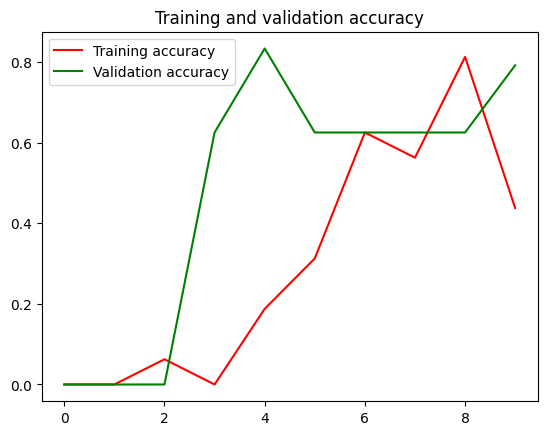

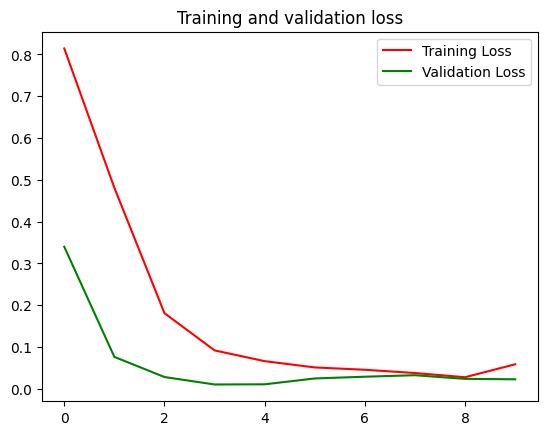

In [ ]:
g_r(vgg_history)

In [ ]:
tf.saved_model.save(model, "vgg_model1")
loaded_model = tf.saved_model.load("vgg_model1")

MobileNet Model

In [ ]:
mobilenet=MobileNet(include_top=False,weights='imagenet',input_shape=(224,224,3))

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99)

In [ ]:
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_acc',verbose=2,factor=0.5,min_lr=0.00001)
callback=[EarlyStop , Reduce_LR]


In [ ]:
mobilenet.trainable=False

In [ ]:
model=Sequential([
    mobilenet,
    MaxPooling2D(3,2),
    Flatten(),
    Dense(128,activation='relu'),
    BatchNormalization(),
    Dense(1024,activation='relu'),
    BatchNormalization(),
    Dense(512,activation='relu'),
    BatchNormalization(),
    Dense(132,activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1024)                │         132,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 132)                 │          67,716 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,139,908 (19.61 MB)

 Trainable params: 1,907,716 (7.28 MB)

 Non-trainable params: 3,232,192 (12.33 MB)

In [ ]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=["accuracy", "Precision", "Recall", "AUC"])

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
history=model.fit(training,validation_data=validing,epochs=50,batch_size=16,
                  steps_per_epoch=len(training) // 16,validation_steps=len(validing) // 8,
                  verbose=1)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - AUC: 0.9992 - Precision: 0.8571 - Recall: 0.7500 - accuracy: 0.8125 - loss: 0.4846 - val_AUC: 0.4450 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 5.9303
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - AUC: 0.9997 - Precision: 0.8750 - Recall: 0.8750 - accuracy: 0.8750 - loss: 0.3425 - val_AUC: 0.5329 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 5.5812
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - AUC: 0.9659 - Precision: 0.8000 - Recall: 0.7500 - accuracy: 0.8125 - loss: 1.1350 - val_AUC: 0.6240 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.1250 - val_loss: 4.8813
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - AUC: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - accuracy: 1.0000 - loss: 0.0600 - val_AUC: 0.6702 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.1667 - val_loss: 4.6201
Epoch 5/50
1

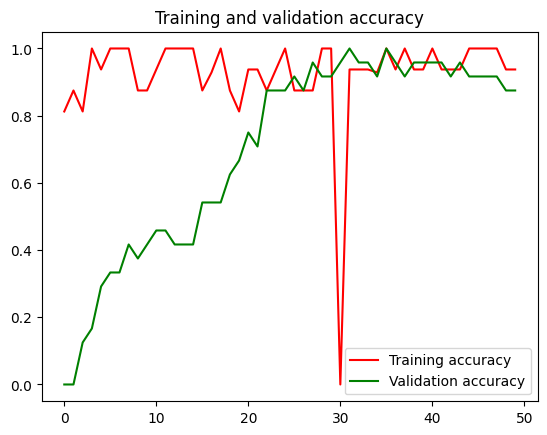

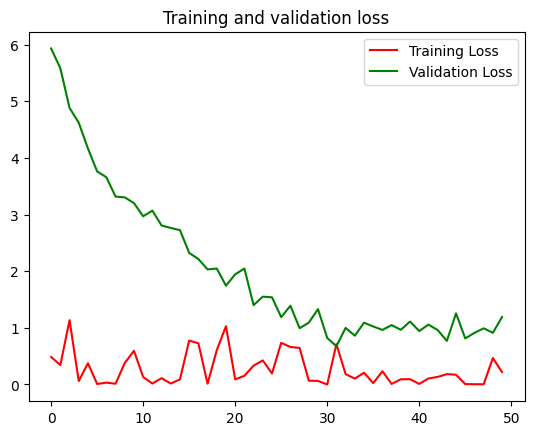

In [ ]:
g_r(history)

In [ ]:
model.save('mobilenet_model1.h5')

In [ ]:
model.save("mobilenet_model1.hdf5")

In [ ]:
import pickle

In [ ]:
# Save the model as a pickle file
with open('mobilenet_model.pickle', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
tf.saved_model.save(model, "mobilenet_model")

In [ ]:
#tf.saved_model.save(model, "mobilenet_model")
loaded_model = tf.saved_model.load("mobilenet_model")

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
def largest(arr,n):
   # Initialize maximum element
   mx = arr[0]

   # Traverse array elements from second
   # and compare every element with
   # current max
   for i in range(1, n):
     if arr[i] > mx:
         mx = arr[i]

   return mx

In [ ]:
test_steps=16

In [ ]:
import tensorflow as tf

def predictor(test_gen, test_steps, cmcmap, loaded_model):
    # ... other parts of your function ...

    # Instead of model.predict, invoke the model like a function:
    preds = loaded_model(test_gen)  # Assuming 'test_gen' is a single batch of data

In [ ]:
error_list = []